# Path Pruning

This notebook will implement a series of path pruning algorithms for the purposes of optimising paths from best-first search algorithms, which are not always optimal.

In [1]:
from queue import PriorityQueue
import numpy as np
from enum import Enum
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from grid import get_data, create_grid
from astar import a_star

*Define some helper functions for viewing results*

In [2]:
# Helper functions

def walkpath(grid, path, start, goal):
    node = (start[0], start[1])
    walked = [np.array(node, dtype=np.int)]
    for i in path:
        node = (node[0] + i[0], node[1] + i[1])
        walked.append(np.array(node, dtype=np.int))
    walked.append(np.array((goal[0], goal[1]), dtype=np.int))
    return walked

def draw_grid(g, cmap = 'Greys', path = [], start = None, goal = None):
    fig = plt.figure(figsize=(10,10))

    plt.imshow(g, cmap=cmap, origin='lower')

    plt.ylabel('NORTH')
    plt.xlabel('EAST')
    plt.ylim(ymin=0, ymax=g.shape[0])
    plt.xlim(xmin=0, xmax=g.shape[1])
    plt.gca().invert_yaxis()
    
    for i in path:
        plt.scatter(int(i[1]), int(i[0]), c='red')
    
    if not start is None:
        plt.scatter(int(start[1]), int(start[0]), c='blue')
    
    if not goal is None:
        plt.scatter(int(goal[1]), int(goal[0]), c='green')

    plt.show()

## Setup

Here we'll define the setup of the path pruning approach.  Using an existing unoptimised path that was found through a previous search, a new more optimal path will be generated while still being admissable.

In [3]:
# Define paths and environment

path = [(-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (10, 10, 1.4142135623730951), (0, 10, 1), (10, 10, 1.4142135623730951), (0, 10, 1), (0, 10, 1), (0, 10, 1), (0, 10, 1), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 0, 1), (-10, 0, 1), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 0, 1), (-10, 0, 1), (-10, -10, 1.4142135623730951), (0, -10, 1), (-10, -10, 1.4142135623730951), (-10, 0, 1), (-10, -10, 1.4142135623730951), (-10, 0, 1), (-10, 0, 1), (-10, 0, 1), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (0, 10, 1), (0, 10, 1), (0, 10, 1), (0, 10, 1), (-10, 10, 1.4142135623730951), (0, 10, 1), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, -10, 1.4142135623730951), (-10, -10, 1.4142135623730951), (-10, -10, 1.4142135623730951), (-10, 0, 1), (-10, 0, 1), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (0, 10, 1), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951), (-10, 10, 1.4142135623730951)]

start = (720, 100)
goal = (10, 730)
data = get_data(skiprows = 3)
grid = create_grid(data, 30, 5)


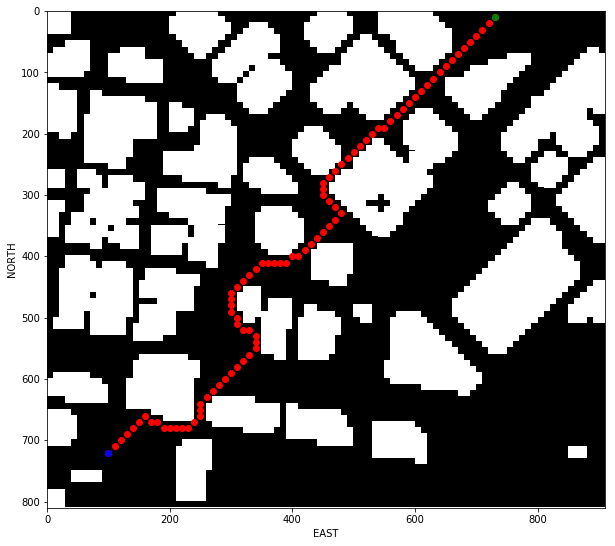

In [4]:
# Visualise the existing path
original = walkpath(grid, path, start, goal)
draw_grid(grid, cmap = 'gray', path = original, start = start, goal = goal)

## Collinear Test

The following implements a collinear determinant based path pruning algorithm for generating an admissable path between the start and goal locations, using the waypoints found from a previous search.

In [5]:
def prune_path(start, goal, path, epsilon = 1e-3):
    """
    Prunes the path to remove redundant states and returns the new path.
    """
    # walk action path
    walked = walkpath(grid, path, start, goal)
    walked = np.array(walked, dtype=np.float)
    walked = np.hstack((np.array(walked), np.ones((walked.shape[0], 1))))
    
    def determinant(p1, p2, p3):
        M = np.vstack((p1, p2, p3))
        return np.linalg.det(M)

    solution = []
    p = 1
    # prune path
    wp = False
    while p <= len(walked)-2:
        col = determinant(walked[p-1], walked[p], walked[p+1])
        #print("[{}] => [{}] => [{}] ::: {}".format(walked[p-1], walked[p], walked[p+1], col))
        col_test = ((-epsilon < col) and (epsilon > col))
        if col_test and not wp:
            solution.append(walked[p])
            wp = True
        elif col_test and wp:
            pass
        else:
            solution.append(walked[p])
            wp = not col_test
        p = p + 1
    
    solution.append(walked[p])
    
    return solution

In [6]:
print("Path length: {}".format(len(path)))

Path length: 87


In [7]:
t0 = time.time()
solution = prune_path(start, goal, path)
wtime = time.time()-t0
print("\nNew path length: {}".format(len(solution)))
print("\nOptimised in {0} sec".format(wtime))


New path length: 26

Optimised in 0.005005598068237305 sec


### New waypoints
*Display the waypoints after pruning...*

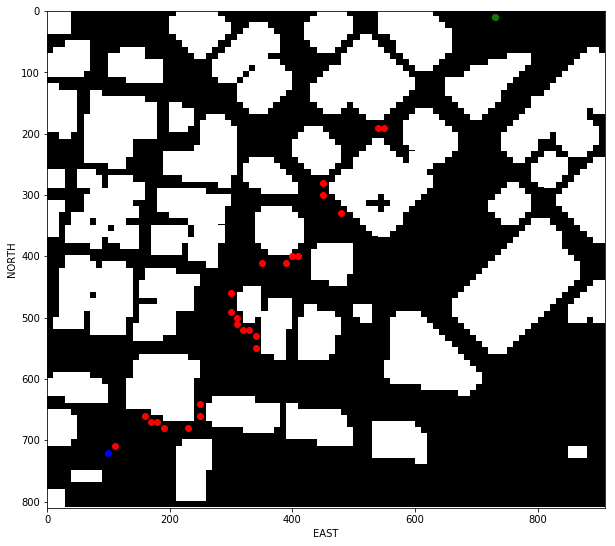

In [8]:
draw_grid(grid, cmap = 'gray', path = solution, start = start, goal = goal)

## Path Expansion

The following implements a path pruning by expansion algorithm which works by finding the longest path between the i-th and i+n-th nodes, resulting in a pruned and more optimal path, while still maintaining admissability.

In [26]:
from bresenham import bresenham

def path_free(grid, node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    cells = list(bresenham(x1, y1, x2, y2))
    
    for (x, y) in cells:
        if grid[x, y] > 0:
            return False
    
    return True

def expand_path(grid, start, goal, path, lookahead = 10, epochs = 1):
    
    search_path = path
    
    for epoch in range(epochs):
        new_path = [start]
        max_ind = len(search_path) - 1
        
        current_node = start
        index = 0
        
        while (index < max_ind):

            max_dist = 0

            for i in range(lookahead):
                new_index = index + i + 0

                if (new_index > max_ind):
                    break

                node = search_path[new_index]

                if (path_free(grid, current_node, node)):
                    dist = np.linalg.norm(np.array(current_node) - np.array(node))
                    if dist > max_dist:
                        max_dist = dist
                        index = new_index

            if (max_dist == 0):
                index += 1

            new_path.append(search_path[index])

            current_node = search_path[index]
        
        search_path = new_path
    
    return new_path
    

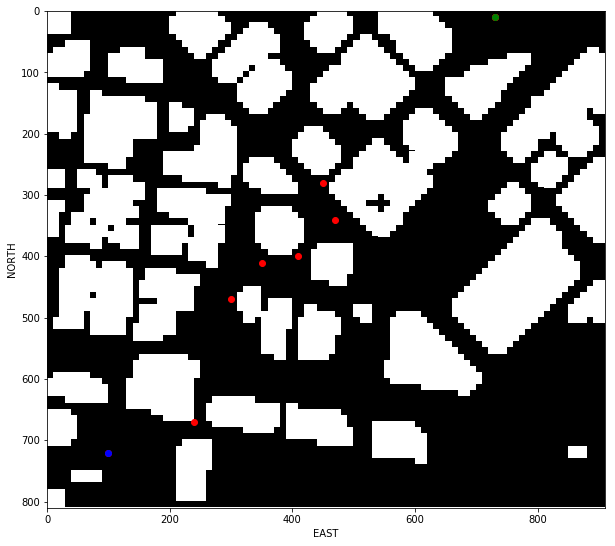


New path length: 9

Optimised in 0.04550313949584961 sec


In [31]:
t1 = time.time()
expanded_path = expand_path(grid, start, goal, original, lookahead = 10, epochs = 2)
w1time = time.time()-t1
draw_grid(grid, cmap = 'gray', path = expanded_path, start = start, goal = goal)

print("\nNew path length: {}".format(len(expanded_path)))
print("\nOptimised in {0} sec".format(w1time))